In [135]:
import sys
import os
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score
from sklearn.linear_model import Ridge
from scipy.optimize import minimize
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings('ignore')


In [136]:
sys.path.append(os.path.abspath("/home/bk_anupam/code/ML/ML_UTILS/"))

In [137]:
import train_tabular_utils as tt
import cv_split_utils
import enums
from enums import ModelName, Metrics
import data_utils

In [138]:
class Config:
    RUN_MODE = "LOCAL"
    RANDOM_SEED = 1
    NUM_FOLDS = 5
    MODEL_TYPE = enums.ModelName.L2_Ridge
    TARGET_COL_NAME = "Target"            
    METRIC = enums.Metrics.ACCURACY
    TRAIN_SINGLE_FOLD = False
    NUM_CLASSES = 3        

COLS_TO_LEAVE = ["id", "Target", "kfold"]
CPU_COUNT = os.cpu_count()

DATA_READPATH = "./data/"
BASE_MODELS_PATH = "./output/"

In [139]:
# key is model type and value is number of trained models for that type to be used in ensemble
models = {
    ModelName.CatBoost: 2,
    ModelName.XGBoost: 1,
    ModelName.LGBM: 1,
    ModelName.RandomForest: 1,
    ModelName.LogisticRegression: 1
}

# base model prediction column names (both for oof predictions and test predictions) are the same as model names
base_model_names = [f"{key}{i+1}" for key, value in models.items() for i in range(value) ]
pred_cols = [f"{model_name}_preds_proba_{i}" for model_name in base_model_names for i in range(Config.NUM_CLASSES)]
print(base_model_names)
pred_cols

['CatBoost1', 'CatBoost2', 'XGBoost1', 'LightGBM1', 'RandomForest1', 'LogisticRegression1']


['CatBoost1_preds_proba_0',
 'CatBoost1_preds_proba_1',
 'CatBoost1_preds_proba_2',
 'CatBoost2_preds_proba_0',
 'CatBoost2_preds_proba_1',
 'CatBoost2_preds_proba_2',
 'XGBoost1_preds_proba_0',
 'XGBoost1_preds_proba_1',
 'XGBoost1_preds_proba_2',
 'LightGBM1_preds_proba_0',
 'LightGBM1_preds_proba_1',
 'LightGBM1_preds_proba_2',
 'RandomForest1_preds_proba_0',
 'RandomForest1_preds_proba_1',
 'RandomForest1_preds_proba_2',
 'LogisticRegression1_preds_proba_0',
 'LogisticRegression1_preds_proba_1',
 'LogisticRegression1_preds_proba_2']

In [140]:
df_submission = pd.read_csv(DATA_READPATH + "sample_submission.csv")
df_oof_preds = pd.DataFrame()
df_test_preds = pd.DataFrame()
# load the OOF csv for each model
for model_name in base_model_names:
    df_model_oof = pd.read_csv(f"{BASE_MODELS_PATH}df_val_preds_{model_name}.csv")
    df_model_test_preds = pd.read_csv(f"{BASE_MODELS_PATH}df_test_preds_{model_name}.csv")
    for i in range(Config.NUM_CLASSES):
        df_oof_preds[f"{model_name}_preds_proba_{i}"] = df_model_oof[f"oof_preds_proba_{i}"]
        df_test_preds[f"{model_name}_preds_proba_{i}"] = df_model_test_preds[f"test_preds_proba_{i}"]
    df_oof_preds[f"{model_name}_preds"] = df_model_oof["oof_preds"]
    df_test_preds[f"{model_name}_preds"] = df_model_test_preds["test_preds"]
df_oof_preds[Config.TARGET_COL_NAME] = df_model_oof[Config.TARGET_COL_NAME]

In [141]:
df_oof_preds.head()

,CatBoost1_preds_proba_0,CatBoost1_preds_proba_1,CatBoost1_preds_proba_2,CatBoost1_preds,CatBoost2_preds_proba_0,CatBoost2_preds_proba_1,CatBoost2_preds_proba_2,CatBoost2_preds,XGBoost1_preds_proba_0,XGBoost1_preds_proba_1,...,LightGBM1_preds,RandomForest1_preds_proba_0,RandomForest1_preds_proba_1,RandomForest1_preds_proba_2,RandomForest1_preds,LogisticRegression1_preds_proba_0,LogisticRegression1_preds_proba_1,LogisticRegression1_preds_proba_2,LogisticRegression1_preds,Target
0,0.007950,0.006622,0.985428,2,0.022356,0.011980,0.965664,2,0.012317,0.010887,...,2,0.012981,0.009251,0.977768,2,0.009403,0.008871,0.981726,2,2
1,0.026453,0.020980,0.952566,2,0.033137,0.018453,0.948410,2,0.028486,0.033435,...,2,0.015810,0.018992,0.965198,2,0.028541,0.058379,0.913080,2,2
2,0.061289,0.621982,0.316728,1,0.056843,0.788141,0.155016,1,0.069910,0.755106,...,1,0.108698,0.641300,0.250002,1,0.077363,0.567161,0.355477,1,1
3,0.221125,0.618871,0.160004,1,0.127717,0.775832,0.096452,1,0.290566,0.487754,...,1,0.201231,0.586526,0.212242,1,0.294388,0.574046,0.131566,1,1
4,0.036233,0.597098,0.366669,1,0.067244,0.587030,0.345726,1,0.079016,0.634216,...,1,0.084981,0.657020,0.257999,1,0.085206,0.550025,0.364769,1,1


In [142]:
df_test_preds.head()

,CatBoost1_preds_proba_0,CatBoost1_preds_proba_1,CatBoost1_preds_proba_2,CatBoost1_preds,CatBoost2_preds_proba_0,CatBoost2_preds_proba_1,CatBoost2_preds_proba_2,CatBoost2_preds,XGBoost1_preds_proba_0,XGBoost1_preds_proba_1,...,LightGBM1_preds_proba_2,LightGBM1_preds,RandomForest1_preds_proba_0,RandomForest1_preds_proba_1,RandomForest1_preds_proba_2,RandomForest1_preds,LogisticRegression1_preds_proba_0,LogisticRegression1_preds_proba_1,LogisticRegression1_preds_proba_2,LogisticRegression1_preds
0,0.990005,0.007855,0.002140,0,0.990935,0.007390,0.001675,0,0.988320,0.008497,...,0.003753,0,0.943398,0.055907,0.000696,0,0.998771,0.001033,0.000197,0
1,0.006233,0.013780,0.979988,2,0.005124,0.011460,0.983416,2,0.007958,0.018430,...,0.985831,2,0.011224,0.015484,0.973292,2,0.004440,0.015403,0.980157,2
2,0.037894,0.251453,0.710653,2,0.034800,0.246753,0.718447,2,0.039474,0.237019,...,0.723582,2,0.057225,0.248017,0.694758,2,0.024246,0.222237,0.753517,2
3,0.183586,0.225122,0.591291,2,0.292535,0.237487,0.469978,2,0.172196,0.458779,...,0.451182,2,0.259611,0.341803,0.398587,2,0.191071,0.414999,0.393930,1
4,0.305291,0.652540,0.042170,1,0.249726,0.712745,0.037528,1,0.345187,0.619451,...,0.026503,1,0.365442,0.573522,0.061035,1,0.264618,0.712037,0.023345,1


In [143]:
def acc_func(weights, oof_preds, target):
    # weighted_preds is the final weighted probability of each target class
    weighted_preds = np.zeros((oof_preds.shape[0], 3))  # Corrected initialization
    # weights sequence length is equal to number of base models
    for i in range(len(weights)):
        # for each base model class probabilites are multiplied with corresponding model weight and added to weighted_preds
        weighted_preds += weights[i] * oof_preds[:, i*3:(i+1)*3]
    # argmax of weighted_preds gives final prediction        
    final_preds = np.argmax(weighted_preds, axis=1)
    accuracy = accuracy_score(target, final_preds)
    print(f"Weights: {weights}, Accuracy: {accuracy}")  # Debug output
    return -accuracy

In [144]:
# Start by giving equal weight to each model
n_models = len(pred_cols) // Config.NUM_CLASSES
initial_weights = np.ones(n_models) / n_models
initial_weights

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

In [145]:
from scipy.optimize import minimize

# We want to find the set of weights that maximizes the accuracy. We start with the initial weights.
target = df_oof_preds[Config.TARGET_COL_NAME]
res = minimize(acc_func, initial_weights, args=(df_oof_preds[pred_cols].to_numpy(), target), method='Nelder-Mead')
model_weights = res["x"]
acc = res["fun"]

Weights: [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667], Accuracy: 0.8320649353858318
Weights: [0.175      0.16666667 0.16666667 0.16666667 0.16666667 0.16666667], Accuracy: 0.8320772899112945
Weights: [0.16666667 0.175      0.16666667 0.16666667 0.16666667 0.16666667], Accuracy: 0.8320402263349065
Weights: [0.16666667 0.16666667 0.175      0.16666667 0.16666667 0.16666667], Accuracy: 0.8320402263349065
Weights: [0.16666667 0.16666667 0.16666667 0.175      0.16666667 0.16666667], Accuracy: 0.8321884806404586
Weights: [0.16666667 0.16666667 0.16666667 0.16666667 0.175      0.16666667], Accuracy: 0.8319908082330558
Weights: [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.175     ], Accuracy: 0.8320525808603692
Weights: [0.16944444 0.16944444 0.16944444 0.16944444 0.15833333 0.16944444], Accuracy: 0.8322008351659212
Weights: [0.17083333 0.17083333 0.17083333 0.17083333 0.15       0.17083333], Accuracy: 0.8322749623186974
Weights: [0.17083333 0.17083333 0.159

In [146]:
model_weights_normalized = model_weights / np.sum(model_weights)
print("Optimal Model Weights:", model_weights_normalized)
print("Optimal Accuracy:", acc)

Optimal Model Weights: [0.17011039 0.16682883 0.16694316 0.17881929 0.14797344 0.16932489]
Optimal Accuracy: -0.8323614439969361


In [147]:
def get_weighted_test_preds_proba(test_preds, model_weights):
    weighted_test_preds_proba = np.zeros((test_preds.shape[0], 3))
    for i in range(len(model_weights)):
        weighted_test_preds_proba += model_weights[i] * test_preds[:, i*3:(i+1)*3]
    return weighted_test_preds_proba

In [148]:
weighted_test_preds_proba = get_weighted_test_preds_proba(df_test_preds[pred_cols].to_numpy(), model_weights_normalized)
ensemble_test_preds = pd.Series(np.argmax(weighted_test_preds_proba, axis=1))
ensemble_test_preds.value_counts()

2    26473
0    15345
1     9194
Name: count, dtype: int64

In [149]:
# Mapping dictionary for class labels
class_mapping = {0: "Dropout", 1: "Enrolled", 2: "Graduate"}
# Replace class labels with corresponding strings using map
ensemble_test_preds = ensemble_test_preds.map(class_mapping)
ensemble_test_preds.value_counts()

Graduate    26473
Dropout     15345
Enrolled     9194
Name: count, dtype: int64

In [150]:
df_submission[Config.TARGET_COL_NAME] = ensemble_test_preds
df_submission.to_csv(BASE_MODELS_PATH + f'submission_ensemble.csv',index=False)
df_submission.head()

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Graduate
4,76522,Enrolled


In [151]:
target_classes = np.array(["Dropout", "Enrolled", "Graduate"])

Ensemble OOF Accuracy: 0.8323614439969361
Ensemble OOF F1 Score: 0.7944577903764874
              precision    recall  f1-score   support

     Dropout       0.90      0.83      0.86     26717
    Enrolled       0.66      0.61      0.63     15734
    Graduate       0.85      0.93      0.89     38491

    accuracy                           0.83     80942
   macro avg       0.80      0.79      0.79     80942
weighted avg       0.83      0.83      0.83     80942



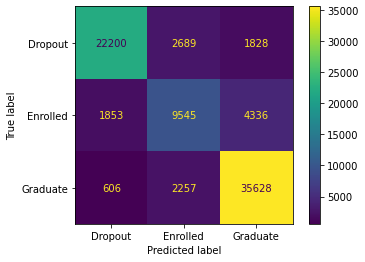

In [152]:
weighted_oof_preds_proba = get_weighted_test_preds_proba(df_oof_preds[pred_cols].to_numpy(), model_weights_normalized)
weighted_oof_preds = np.argmax(weighted_oof_preds_proba, axis=1)
weighted_oof_accuracy = accuracy_score(df_oof_preds[Config.TARGET_COL_NAME], weighted_oof_preds)
ensemble_f1_score = f1_score(df_oof_preds[Config.TARGET_COL_NAME], weighted_oof_preds, average='macro')
print(f"Ensemble OOF Accuracy: {weighted_oof_accuracy}")
print(f"Ensemble OOF F1 Score: {ensemble_f1_score}")
ensemble_cm = confusion_matrix(df_oof_preds[Config.TARGET_COL_NAME], weighted_oof_preds)
print(classification_report(df_oof_preds[Config.TARGET_COL_NAME].values, weighted_oof_preds, target_names=target_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=ensemble_cm, display_labels=target_classes)
disp.plot()
plt.show()

In [153]:
def get_model_stats(model_name):    
    model_cols = [f"{model_name}_preds_proba_{i}" for i in range(Config.NUM_CLASSES)]
    model_preds_proba = df_oof_preds[model_cols].to_numpy()
    model_preds = np.argmax(model_preds_proba, axis=1)
    model_accuracy = accuracy_score(df_oof_preds[Config.TARGET_COL_NAME], model_preds)
    model_f1 = f1_score(df_oof_preds[Config.TARGET_COL_NAME], model_preds, average='macro')
    print(f"{model_name} OOF Accuracy: {model_accuracy}")
    print(f"{model_name} OOF F1 Score: {model_f1}")
    model_cm = confusion_matrix(df_oof_preds[Config.TARGET_COL_NAME], model_preds)
    print(classification_report(df_oof_preds[Config.TARGET_COL_NAME].values, model_preds, target_names=target_classes))
    disp = ConfusionMatrixDisplay(confusion_matrix=model_cm, display_labels=target_classes)
    disp.plot()
    plt.show()

LightGBM1 OOF Accuracy: 0.8335598329668158
LightGBM1 OOF F1 Score: 0.7961193643046242
              precision    recall  f1-score   support

     Dropout       0.90      0.83      0.87     26717
    Enrolled       0.66      0.61      0.64     15734
    Graduate       0.86      0.92      0.89     38491

    accuracy                           0.83     80942
   macro avg       0.80      0.79      0.80     80942
weighted avg       0.83      0.83      0.83     80942



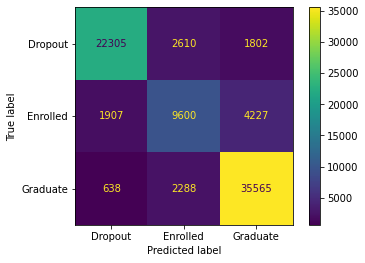

In [154]:
get_model_stats("LightGBM1")